# Train a Bayesian Layer Model for MNIST classification

In this notebook, we will train an MNIST convolutional classifier with a Bayesian last layer. First, we train a determinstic classifier to obtain a MAP estimate of the weights. Then, we replace the last layer of this model with a Bayesian last layer and train the layer using Stochastic Gradient Hamiltonian Monte Carlo (we keep the backbone fixed). 

## Setup


Import libraries

In [1]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

import models.BLL
import models.mnist_classifier_BLL
import train
import sampler


Set the configuration

In [2]:
# 1. Configuration
class Config:
    # Data
    batch_size = 512
    
    # Backbone training
    backbone_epochs = 12
    backbone_lr = 0.001
    backbone_patience = 5
    
    # BLL training
    bll_epochs = 100
    bll_lr = 0.5e-2
    bll_base_C = 0.05
    bll_gauss_sig = 0.1
    
    # SGHMC parameters
    burn_in = 10
    re_burn = 1e7
    sim_steps = 2      # Save model every N epochs
    N_saves = 20       # Maximum ensemble size
    resample_its = 10  # Resample momentum every N iterations
    resample_prior_its = 45
    nb_its_dev = 1     # Evaluate on validation set every epoch
    
    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'
    
cfg = Config()

Load the Datasets

In [3]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)

Create a models and results directory if it doesn't exist

In [4]:
models_dir = '../model_saves'
results_dir = '../results'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Backbone
We'll start with the backbone training.

### Backbone 

Load model

In [5]:
from models.mnist_classifier_BLL import MNISTClassifierBLL
importlib.reload(models.mnist_classifier_BLL)


backbone = MNISTClassifierBLL(device=cfg.device)
print(f"Backbone will run on: {cfg.device}")

Backbone will run on: mps


Train model

In [ ]:
from train import train_backbone
importlib.reload(train)

cost_tr, cost_dev, err_tr, err_dev, best_err = train_backbone(
    net=backbone,
    name='mnist_backbone',
    batch_size=cfg.batch_size,
    nb_epochs=cfg.backbone_epochs,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    lr=cfg.backbone_lr,
    patience=cfg.backbone_patience,
    model_saves_dir=models_dir
)

print(f"\nBackbone training completed! Best validation error: {best_err:.4f}")

### Load weights


In [6]:
backbone.load_weights(models_dir + '/mnist_backbone_models/backbone_best_12_epochs.pt')

 [load_weights] Loaded backbone weights from ../model_saves/mnist_backbone_models/backbone_best_12_epochs.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/mnist_classifier_BLL.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

## Bayesian Last Layer - SGHMC
Next we'll train the Bayesian last layer on the penultimate layer representations of the backbone.

### Load the model

In [7]:
from models.BLL import BayesianLastLayerCat
importlib.reload(models.BLL)

bll = BayesianLastLayerCat(
    backbone=backbone,
    input_dim=256,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    N_train=len(trainset),
    lr=cfg.bll_lr,
    base_C=cfg.bll_base_C,
    gauss_sig=cfg.bll_gauss_sig,
    device=cfg.device
)

### Train the model


Network:

Train:
  init cost variables:
it 0/100, Jtr_pred = 0.001841, err = 0.230521,    time: 8.050016 seconds

 [update_lr] Learning rate: 0.004950  (epoch 0)
    Jdev = 0.260243, err = 0.016083

best validation error
it 1/100, Jtr_pred = 0.000239, err = 0.008854,    time: 6.586143 seconds

 [update_lr] Learning rate: 0.004901  (epoch 1)
    Jdev = 0.056656, err = 0.005583

best validation error
it 2/100, Jtr_pred = 0.000079, err = 0.004687,    time: 6.346368 seconds

 [update_lr] Learning rate: 0.004851  (epoch 2)
    Jdev = 0.028969, err = 0.003500

best validation error
it 3/100, Jtr_pred = 0.000050, err = 0.003875,    time: 6.400265 seconds

 [update_lr] Learning rate: 0.004803  (epoch 3)
    Jdev = 0.020955, err = 0.002500

best validation error
it 4/100, Jtr_pred = 0.000040, err = 0.003458,    time: 7.184983 seconds

 [update_lr] Learning rate: 0.004755  (epoch 4)
    Jdev = 0.018075, err = 0.002667

it 5/100, Jtr_pred = 0.000035, err = 0.003187,    time: 6.460985 seconds

 [

<Figure size 640x480 with 0 Axes>

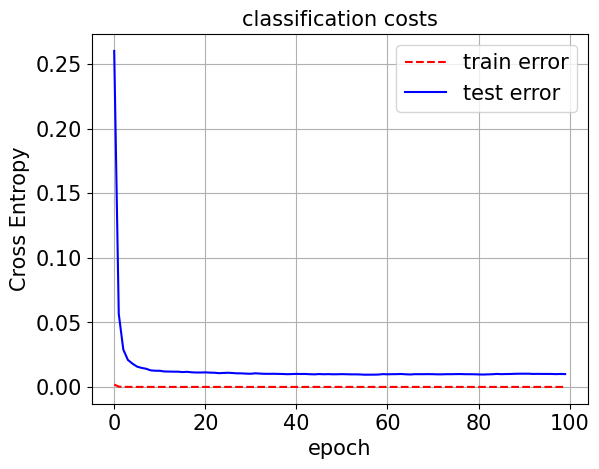

<Figure size 640x480 with 0 Axes>

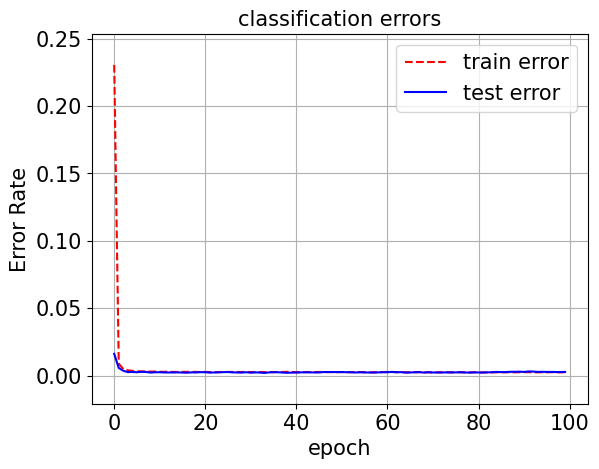

In [8]:
from train import train_BLL_classification
importlib.reload(train)

bll_cost_tr, bll_cost_dev, bll_err_tr, bll_err_dev = train_BLL_classification(
    net=bll,
    name='mnist_bll',
    batch_size=cfg.batch_size,
    nb_epochs=cfg.bll_epochs,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    burn_in=cfg.burn_in,
    sim_steps=cfg.sim_steps,
    N_saves=cfg.N_saves,
    resample_its=cfg.resample_its,
    resample_prior_its=cfg.resample_prior_its,
    re_burn=cfg.re_burn,
    nb_its_dev=cfg.nb_its_dev,
    model_saves_dir=models_dir
)

### Test the model

To check for Bayesian behaviour, we find an uncertain prediction and visualize multiple samples from the posterior.

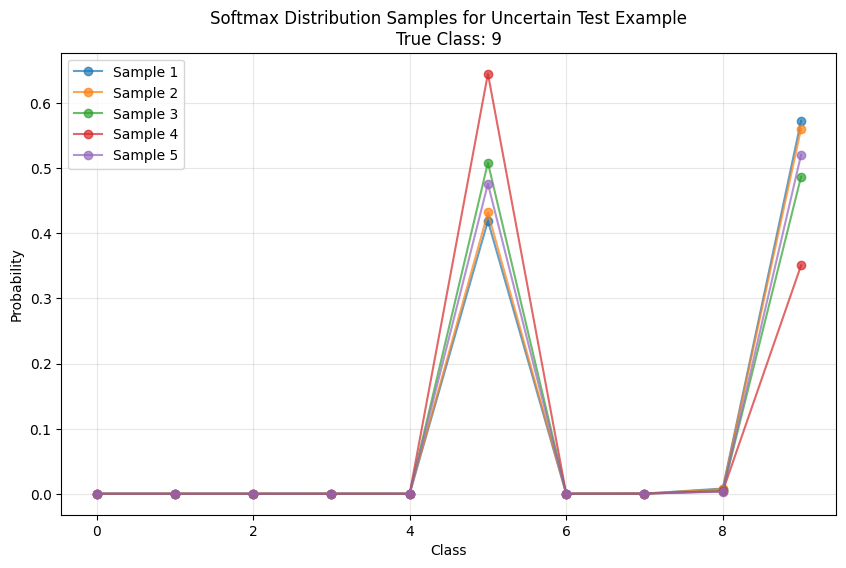

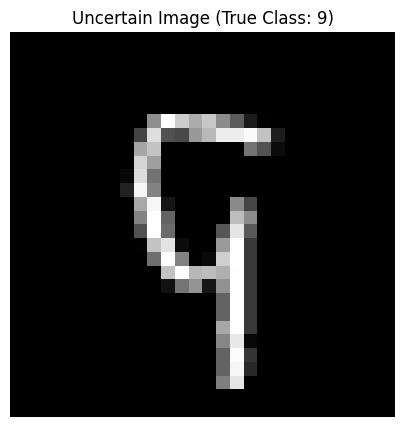

In [19]:
# Search for a test example with uncertain predictions
test_iter = iter(testloader)
found_uncertain = False
max_tries = 100
num_samples = 5

try:
    while not found_uncertain:
        x, y = next(test_iter)
        # Look at each example in the batch
        for i in range(len(x)):
            x_single = x[i:i+1]
            y_single = y[i:i+1]
            
            # Get predictions from 5 different ensemble members
            probs = bll.sample_predict(x_single, Nsamples=num_samples)  # Shape: [5, 1, num_classes]
            probs = probs.squeeze(1)  # Remove batch dimension -> [5, num_classes]
            
            # Check if predictions are not all highly confident
            max_probs = probs.max(dim=1)[0]
            if max_probs.mean() < 0.6:  # If average confidence is less than 99.9%
                found_uncertain = True
                break
                
except StopIteration:
    if not found_uncertain:
        print("Could not find uncertain prediction in entire test set")

# Plot the softmax distributions
plt.figure(figsize=(10, 6))
x_axis = range(probs.shape[1])  # Range over number of classes

for i in range(num_samples):
    plt.plot(x_axis, probs[i].cpu().numpy(), 'o-', alpha=0.7, label=f'Sample {i+1}')

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'Softmax Distribution Samples for Uncertain Test Example\nTrue Class: {y_single.item()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display the uncertain image
plt.figure(figsize=(5, 5))
img = x_single.squeeze().cpu()
if img.shape[0] == 1:  # If grayscale, remove channel dimension
    img = img.squeeze(0)
plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.axis('off')
plt.title(f'Uncertain Image (True Class: {y_single.item()})')
plt.show()


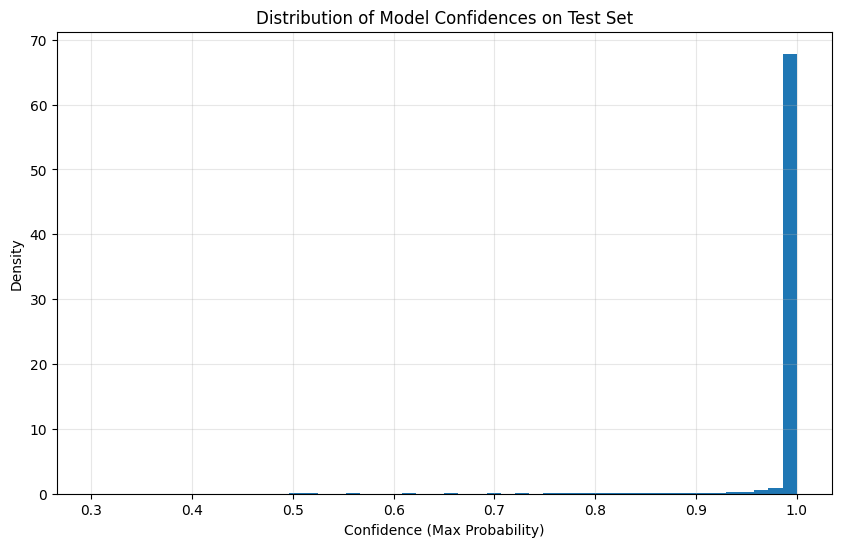

In [11]:
# Get predictions and confidences for entire test set
all_confidences = []

for x, y in testloader:
    # Get predictions from ensemble
    probs = bll.sample_predict(x)  # Shape: [n_ensemble, batch_size, num_classes]
    
    # Average probabilities across ensemble members
    mean_probs = probs.mean(dim=0)  # Shape: [batch_size, num_classes]
    
    # Get maximum probability (confidence) for each prediction
    confidences = mean_probs.max(dim=1)[0]
    all_confidences.extend(confidences.cpu().numpy())

# Plot histogram of confidences
plt.figure(figsize=(10, 6))
plt.hist(all_confidences, bins=50, density=True)
plt.xlabel('Confidence (Max Probability)')
plt.ylabel('Density')
plt.title('Distribution of Model Confidences on Test Set')
plt.grid(True, alpha=0.3)
plt.show()


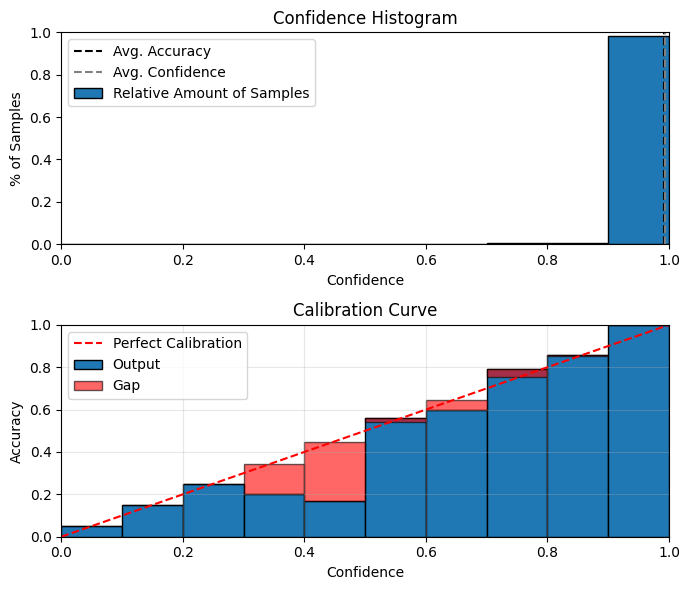

In [12]:
# Get predictions and ground truth labels for calibration curve
all_probs = []
all_labels = []

for x, y in testloader:
    # Get predictions from ensemble
    probs = bll.sample_predict(x)  # Shape: [n_ensemble, batch_size, num_classes]
    
    # Average probabilities across ensemble members
    mean_probs = probs.mean(dim=0)  # Shape: [batch_size, num_classes]
    
    all_probs.extend(mean_probs.cpu().numpy())
    all_labels.extend(y.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Create reliability diagram
from netcal.presentation import ReliabilityDiagram

# Initialize reliability diagram with 10 bins
diagram = ReliabilityDiagram(10)

# Plot calibration curve
diagram.plot(all_probs, all_labels)
plt.title('Calibration Curve')
plt.grid(True, alpha=0.3)
plt.show()


## Bayesian Last Layer - VI
Next we'll train a variational inference version of the Bayesian last layer using the same backbone.


### Load the model

In [12]:
from models.BLL_VI import BayesianLastLayerVI
importlib.reload(models.BLL_VI)

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

bll_vi = BayesianLastLayerVI(
    backbone=backbone,
    input_dim=256,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    prior_mu=0.0,
    prior_sigma=0.1,
    kl_weight=0.1,  # Weight of KL divergence term
    device=cfg.device
)

# Verify all model components are on the correct device
print(f"Backbone device: {next(bll_vi.backbone.parameters()).device}")
print(f"Last layer device: {next(bll_vi.last_layer.parameters()).device}")

Backbone device: mps:0
Last layer device: mps:0


### Train the model

In [13]:
from train import train_BLL_VI_classification
importlib.reload(train)

vi_cost_tr, vi_cost_dev, vi_err_tr, vi_err_dev, vi_kl = train_BLL_VI_classification(
    net=bll_vi,
    name='mnist_bll_vi',
    batch_size=cfg.batch_size,
    nb_epochs=10,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    lr=1e-3,
    patience=5,
    nb_its_dev=1,
    model_saves_dir=models_dir
)


Bayesian Last Layer (VI):
it 0/10, Jtr = 0.002, err = 0.271, KL = 0.088,    time: 7.991567 seconds

    Jdev = 0.033, err = 0.010

best validation error
it 1/10, Jtr = 0.000, err = 0.050, KL = 0.122,    time: 7.038792 seconds

    Jdev = 0.022, err = 0.007

best validation error
it 2/10, Jtr = 0.000, err = 0.036, KL = 0.141,    time: 7.381385 seconds

    Jdev = 0.016, err = 0.005

best validation error
it 3/10, Jtr = 0.000, err = 0.023, KL = 0.156,    time: 9.354598 seconds

    Jdev = 0.016, err = 0.005

best validation error
it 4/10, Jtr = 0.000, err = 0.020, KL = 0.167,    time: 7.653568 seconds

    Jdev = 0.015, err = 0.005

it 5/10, Jtr = 0.000, err = 0.019, KL = 0.179,    time: 7.126051 seconds

    Jdev = 0.013, err = 0.004

best validation error
it 6/10, Jtr = 0.000, err = 0.017, KL = 0.187,    time: 7.302498 seconds

    Jdev = 0.012, err = 0.004

best validation error
it 7/10, Jtr = 0.000, err = 0.014, KL = 0.195,    time: 7.921500 seconds

    Jdev = 0.012, err = 0.004

b

<Figure size 640x480 with 0 Axes>

### Test the model
To check for Bayesian behaviour, we find an uncertain prediction and visualize multiple samples from the posterior.


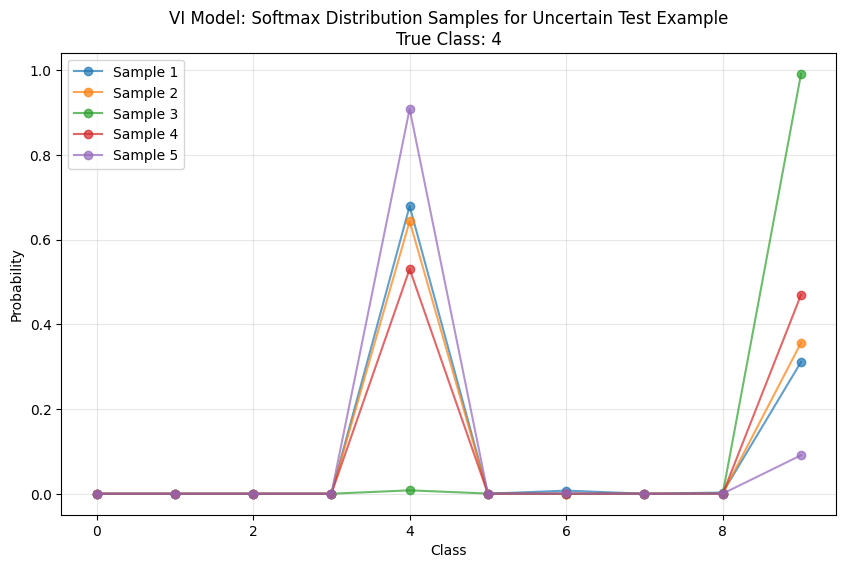

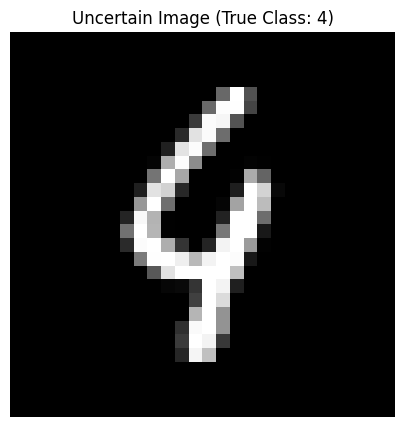

In [17]:
import torch.nn.functional as F

# Search for an uncertain prediction and visualize multiple samples
test_iter = iter(testloader)
found_uncertain = False
max_tries = 100
num_samples = 5

try:
    while not found_uncertain:
        x, y = next(test_iter)
        # Look at each example in the batch
        for i in range(len(x)):
            x_single = x[i:i+1]
            y_single = y[i:i+1]
            
            # Get multiple predictions for this single example
            outputs = []
            with torch.no_grad():  # Add no_grad context
                for _ in range(num_samples):
                    logits = bll_vi(x_single)
                    probs = F.softmax(logits, dim=1)
                    outputs.append(probs)
            
            # Stack predictions
            probs = torch.stack(outputs)  # Shape: [num_samples, 1, num_classes]
            probs = probs.squeeze(1)  # Remove batch dimension -> [num_samples, num_classes]
            
            # Check if predictions are not all highly confident
            max_probs = probs.max(dim=1)[0]
            if max_probs.mean() < 0.8:  # If average confidence is less than 60%
                found_uncertain = True
                break
                
except StopIteration:
    if not found_uncertain:
        print("Could not find uncertain prediction in entire test set")

# Plot the softmax distributions
plt.figure(figsize=(10, 6))
x_axis = range(probs.shape[1])  # Range over number of classes

for i in range(num_samples):
    plt.plot(x_axis, probs[i].detach().cpu().numpy(), 'o-', alpha=0.7, label=f'Sample {i+1}')

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'VI Model: Softmax Distribution Samples for Uncertain Test Example\nTrue Class: {y_single.item()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display the uncertain image
plt.figure(figsize=(5, 5))
img = x_single.squeeze().cpu()
if img.shape[0] == 1:  # If grayscale, remove channel dimension
    img = img.squeeze(0)
plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.axis('off')
plt.title(f'Uncertain Image (True Class: {y_single.item()})')
plt.show()